In [6]:
import pandas as pd
import numpy as np
import os
from os import listdir

In [13]:
folder_path = '/home/david/Documents/DataScienceDocs/StateSTNs/'
folders_tmp = [f for f in listdir(folder_path)]
folders = [folder_path + str(i) for i in folders_tmp]
for state_folder in folders:
    files = [f for f in listdir(state_folder)]
    state_wbans = []
    for file in files:
        state_wbans.append("%05d" % int(os.path.splitext(file)[0]))
    print(state_wbans)
#Louisiana location is Little Rock, latitude is  34.91667


['03878', '63862', '53843', '63858', '73803', '73802', '53861', '03892', '63880', '63895', '63868', '63885', '03896', '63883', '63833', '13829', '13895', '13838', '03850', '63891', '63894', '13871', '13876', '63870', '00138', '13896', '63893', '93806', '00186', '63892', '63899', '63867', '63847', '63874', '23802', '13894', '63804', '13821', '63896', '53852', '23801', '53864', '63839', '13839', '63872', '63897', '63873', '63857', '53820', '63869']


In [ ]:
df_l = pd.read_csv('/home/david/Documents/DataScienceDocs/StateSTNs/AlabamaSTNs/03878.csv', delimiter=',')

In [5]:
for col in df_l.columns:
    print(col)

STATION
DATE
REPORT_TYPE
SOURCE
AWND
BackupDirection
BackupDistance
BackupDistanceUnit
BackupElements
BackupElevation
BackupElevationUnit
BackupEquipment
BackupLatitude
BackupLongitude
BackupName
CDSD
CLDD
DSNW
DailyAverageDewPointTemperature
DailyAverageDryBulbTemperature
DailyAverageRelativeHumidity
DailyAverageSeaLevelPressure
DailyAverageStationPressure
DailyAverageWetBulbTemperature
DailyAverageWindSpeed
DailyCoolingDegreeDays
DailyDepartureFromNormalAverageTemperature
DailyHeatingDegreeDays
DailyMaximumDryBulbTemperature
DailyMinimumDryBulbTemperature
DailyPeakWindDirection
DailyPeakWindSpeed
DailyPrecipitation
DailySnowDepth
DailySnowfall
DailySustainedWindDirection
DailySustainedWindSpeed
DailyWeather
HDSD
HTDD
HeavyFog
HourlyAltimeterSetting
HourlyDewPointTemperature
HourlyDryBulbTemperature
HourlyPrecipitation
HourlyPresentWeatherType
HourlyPressureChange
HourlyPressureTendency
HourlyRelativeHumidity
HourlySeaLevelPressure
HourlySkyConditions
HourlyStationPressure
HourlyVisib

In [6]:
df_l["DATE"] = pd.to_datetime(df_l["DATE"])

In [7]:
#calculating solar insolation from cloud coverage data in 
#HourlySkyConditions
print(df_l["DATE"].count())
#First need to remove NaN, then parse out all info 
df_l = df_l[pd.isna(df_l["HourlySkyConditions"]) == False]
print(df_l["DATE"].count())

134358
106351


In [8]:
# Cloud coverage data can 3 have 3 layers, all with 3 components
#Component 1 is a name, comp. 2 i okta, comp. 3 is cloud heigh (in 1000 ft)

#Splitting data into separate columns
df_test = df_l["HourlySkyConditions"].str.split(" ", n=6, expand = True)

In [9]:
df_test0 = df_test[0].str.split(":", n=1, expand = True)
df_test2 = df_test[2].str.split(":", n=1, expand = True)
df_test4 = df_test[4].str.split(":", n=1, expand = True)

In [10]:
cloud_data = { 'CLOUD LAYER 1 NAME' : df_test0[0],
            'CLOUD LAYER 1 OCTA' : df_test0[1],
            'CLOUD LAYER 1 HEIGHT' : df_test[1],
            'CLOUD LAYER 2 NAME' : df_test2[0],
            'CLOUD LAYER 2 OCTA' : df_test2[1],
            'CLOUD LAYER 2 HEIGHT' : df_test[3],
            'CLOUD LAYER 3 NAME' : df_test4[0],
            'CLOUD LAYER 3 OCTA' : df_test4[1],
            'CLOUD LAYER 3 HEIGHT' :  df_test[5] }

In [11]:
df_cloud = pd.DataFrame(cloud_data)

In [12]:
new_df = pd.concat([df_l, df_cloud], axis = 1)

In [13]:
def solar_insolation_value (row):
    from numpy.core.umath import deg2rad
    louisiana_lat = deg2rad(34.91667)
    louisiana_long = -92.2892
    time_zone = -6
    adjusted_solar_noon = 12 + (((time_zone*15) - louisiana_long) / 15 ) 
    solar_constant = 1362
   # hour_angle = deg2rad(15) * (row["DATE"].hour + (row["DATE"].minute / 60.) - (12 + (12/60) + (57/3600)))
    hour_angle = deg2rad(15) * (row["DATE"].hour + (row["DATE"].minute / 60.) - adjusted_solar_noon)
    dec_angle = (deg2rad(-23.45) * np.cos(deg2rad(360) * (row["DATE"].day + 10) / 365))
    
    zenith_angle = np.arccos(np.sin(louisiana_lat)*np.sin(dec_angle) + 
                            np.cos(louisiana_lat)*np.cos(dec_angle)*np.cos(hour_angle))
    
    if np.cos(zenith_angle) < 0:
    #At night time, so solar insolation is negligible
        return 0
    else:
        return solar_constant * np.cos(zenith_angle)


In [14]:
right_values = new_df.apply(lambda row : solar_insolation_value(row), axis = 1)
new_df["SOLAR INSOLATION"] = new_df.apply(lambda row: solar_insolation_value(row), axis = 1)

In [15]:
#Sunrise time on Jan1 2013 : 17:17
print( new_df["DATE"].iloc[42], " ", new_df["SOLAR INSOLATION"].iloc[42])
print( new_df["DATE"].iloc[43], " ", new_df["SOLAR INSOLATION"].iloc[43])

2009-01-02 17:45:00   0.0
2009-01-02 17:53:00   0.0


In [26]:
#Sunset time : 17:09
print( new_df["DATE"].iloc[63], " ", new_df["SOLAR INSOLATION"].iloc[63])
print( new_df["DATE"].iloc[64], " ", new_df["SOLAR INSOLATION"].iloc[64])

2013-01-01 16:55:00   21.79808018794936
2013-01-01 17:17:00   0.0


In [1]:
print( new_df["DATE"].iloc[1463], " ", new_df["SOLAR INSOLATION"].iloc[1463])
print( new_df["DATE"].iloc[1464], " ", new_df["SOLAR INSOLATION"].iloc[1464])

NameError: name 'new_df' is not defined

In [27]:
#Looking at coverage fractions only as of now

octa_h20_dict = {0 : (235/235), 1 : (247/245), 2 : (230/235),
                 3 : (228/235), 4 : (199/235), 5 : (155/235),
                 6 : (152/235), 7 : (129/235), 8 : (62/235)}

octa_h30_dict = {0 : (354/354), 1 : (399/354), 2 : (301/354),
                 3 : (295/354), 4 : (287/354), 5 : (272/354),
                 6 : (233/354), 7 : (169/354), 8 : (109/354)}

octa_h40_dict = {0 : (531/531), 1 : (525/531), 2 : (502/531),
                 3 : (467/531), 4 : (423/531), 5 : (408/531),
                 6 : (359/531), 7 : (311/531), 8 : (178/531)}

octa_h50_dict = {0 : (668/668), 1 : (653/668), 2 : (623/668),
                 3 : (612/668), 4 : (546/668), 5 : (483/668),
                 6 : (425/668), 7 : (367/668), 8 : (196/668)}

octa_h60_dict = {0 : (751/751), 1 : (775/751), 2 : (725/751),
                 3 : (714/751), 4 : (590/751), 5 : (582/751),
                 6 : (574/751), 7 : (387/751), 8 : (219/751)}

octa_hplus_dict = {0 : (819/819), 1 : (825/819), 2 : (807/819),
                   3 : (767/819), 4 : (752/819), 5 : (624/819),
                   6 : (599/819), 7 : (475/819), 8 : (270/819)}

def determine_dict(zenith_angle):
    if zenith_angle < 20.:
        return octa_h20_dict
    elif zenith_angle < 30.:
        return octa_h30_dict
    elif zenith_angle < 40.:
        return octa_h40_dict
    elif zenith_angle < 50.:
        return octa_h50_dict
    elif zenith_angle < 60.:
        return octa_h60_dict
    else:
        return octa_hplus_dict

In [28]:
import numpy as np

In [29]:
years = new_df["DATE"].dt.year.unique()
months = new_df["DATE"].dt.month.unique()
days = new_df["DATE"].dt.day.unique()

In [30]:
import re
def digitize(row, column):
    return re.sub("\D", "", str(row[column]))

new_df["CLOUD LAYER 1 OCTA"] = new_df.apply(lambda row: digitize(row, "CLOUD LAYER 1 OCTA"), axis = 1)
new_df["CLOUD LAYER 2 OCTA"] = new_df.apply(lambda row: digitize(row, "CLOUD LAYER 2 OCTA"), axis = 1)
new_df["CLOUD LAYER 3 OCTA"] = new_df.apply(lambda row: digitize(row, "CLOUD LAYER 3 OCTA"), axis = 1)

In [113]:
yearly_averages = []
monthly_averages = []
daily_averages = []
monthly_cloudiness = []
cumulative_day = 0
for year in years:
    integrated_sol_ins_year = 0.0
    for month in months:
        integrated_sol_ins_month = 0.0
        cloud_hours_dict = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0,
                    5: 0, 6: 0, 7: 0, 8: 0}

        for day in days:            
            cumulative_day +=1
            cond_year = new_df["DATE"].dt.year == year
            cond_month = new_df["DATE"].dt.month == month
            cond_day = new_df["DATE"].dt.day == day
            
            df_temp = new_df[cond_year & cond_month & cond_day]
            
            integrated_sol_ins = 0.0
            day_measurements = 0
            cloud_hours_dict_day = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0,
                                5: 0, 6: 0, 7: 0, 8: 0}

            for row in range(1, df_temp["DATE"].count()):
                day_measurements +=1
                #Creating daily average graph
                octa_1 = 0
                octa_2 = 0
                octa_3 = 0
                del_t = df_temp["DATE"].iloc[row] - df_temp["DATE"].iloc[row-1]
                sol_ins_avg = (df_temp["SOLAR INSOLATION"].iloc[row] + 
                              df_temp["SOLAR INSOLATION"].iloc[row-1])/2.
                #Value in kWh
                if pd.isna(df_temp["CLOUD LAYER 3 OCTA"].iloc[row]) == False:
                    if df_temp["CLOUD LAYER 3 OCTA"].iloc[row] != '' :
                        octa_3 = int(df_temp["CLOUD LAYER 3 OCTA"].iloc[row])
                if pd.isna(df_temp["CLOUD LAYER 2 OCTA"].iloc[row]) == False:
                    if df_temp["CLOUD LAYER 2 OCTA"].iloc[row] != '' :    
                        octa_2 = int(df_temp["CLOUD LAYER 2 OCTA"].iloc[row])
                if pd.isna(df_temp["CLOUD LAYER 1 OCTA"].iloc[row] == False):
                    if df_temp["CLOUD LAYER 1 OCTA"].iloc[row] != '' :
                        octa_1 = int(df_temp["CLOUD LAYER 1 OCTA"].iloc[row])
    
                max_octa = max(octa_1, octa_2, octa_3)
                #VV and code 9 indicates obstructed sky - lookup codes avaialable to
                #find specific reason, but for now reduce to full coverage
                if max_octa > 8:
                    max_octa = 8
                    
                zenith_angle = np.arccos(df_temp["SOLAR INSOLATION"].iloc[row] / 1362)
                dict = determine_dict(zenith_angle)
                #solar insolation measured in kWh / m^2, so divide by 1000
                integrated_sol_ins += (del_t.seconds/3600.) * sol_ins_avg * dict[max_octa]
           
                #cloudiness hours heat map calc
                cloud_hours_dict_day.update({max_octa : cloud_hours_dict_day[max_octa] + 1})
            
            #dividing by total number of day measurements to normalize to 1
  #          print(day_measurements)
  #          print(cloud_hours_dict)
            for item in cloud_hours_dict:
                if day_measurements > 0.0:
                    cloud_hours_dict.update({item : cloud_hours_dict[item] + 
                                             (cloud_hours_dict_day[item] / day_measurements)})
                
            daily_averages.append([year, month, day, cumulative_day, integrated_sol_ins])
            integrated_sol_ins_month += integrated_sol_ins
            
        dict_list = []
        dict_list.append(year) 
        dict_list.append(month)
        for item in cloud_hours_dict:
            dict_list.append(cloud_hours_dict[item])
        monthly_cloudiness.append(dict_list)    
        monthly_averages.append([year, month, integrated_sol_ins_month])
        integrated_sol_ins_year += integrated_sol_ins_month
    yearly_averages.append([year, integrated_sol_ins_year])
            
            

In [114]:
daily_df = pd.DataFrame(np.array(daily_averages),
                        columns = ["Year", "Month", "Day", 
                                   "Cumulative Day", "Solar Insolation kWh / m^2 / day"])

daily_df["Solar Insolation kWh / m^2 / day"] = daily_df["Solar Insolation kWh / m^2 / day"] / 1000.

monthly_df = pd.DataFrame(np.array(monthly_averages),
                          columns = ["Year", "Month", "Solar Insolation kWh / m^2 / day"])

monthly_df["Solar Insolation kWh / m^2 / day"] = monthly_df["Solar Insolation kWh / m^2 / day"] / (1000 * 30)

yearly_df = pd.DataFrame(np.array(yearly_averages),
                        columns = ["Year", "Solar Insolation kWh / m^2 / day"])
yearly_df["Solar Insolation kWh / m^2 / day"] = yearly_df["Solar Insolation kWh / m^2 / day"] / (1000 * 365)


In [115]:
#Looking at how many days had no data for clouds
years = daily_df["Year"].unique()
months = daily_df["Month"].unique()
for year in years:
    for month in months:
        df_temp = daily_df[daily_df["Year"] == year]
        df_temp = df_temp[df_temp["Month"] == month]
        df_numzeroes = df_temp[df_temp["Solar Insolation kWh / m^2 / day"] == 0.0]
    
        print(year, " ", month, " ", df_numzeroes["Year"].count())

2013.0   1.0   7
2013.0   2.0   9
2013.0   3.0   5
2013.0   4.0   6
2013.0   5.0   0
2013.0   6.0   1
2013.0   7.0   0
2013.0   8.0   0
2013.0   9.0   1
2013.0   10.0   0
2013.0   11.0   1
2013.0   12.0   0
2014.0   1.0   0
2014.0   2.0   3
2014.0   3.0   0
2014.0   4.0   1
2014.0   5.0   0
2014.0   6.0   1
2014.0   7.0   1
2014.0   8.0   0
2014.0   9.0   1
2014.0   10.0   0
2014.0   11.0   1
2014.0   12.0   0
2015.0   1.0   0
2015.0   2.0   5
2015.0   3.0   0
2015.0   4.0   4
2015.0   5.0   0
2015.0   6.0   1
2015.0   7.0   0
2015.0   8.0   0
2015.0   9.0   1
2015.0   10.0   0
2015.0   11.0   1
2015.0   12.0   1
2016.0   1.0   0
2016.0   2.0   2
2016.0   3.0   0
2016.0   4.0   1
2016.0   5.0   0
2016.0   6.0   1
2016.0   7.0   0
2016.0   8.0   0
2016.0   9.0   1
2016.0   10.0   0
2016.0   11.0   1
2016.0   12.0   7
2017.0   1.0   0
2017.0   2.0   4
2017.0   3.0   0
2017.0   4.0   2
2017.0   5.0   0
2017.0   6.0   1
2017.0   7.0   0
2017.0   8.0   0
2017.0   9.0   2
2017.0   10.0   0
2

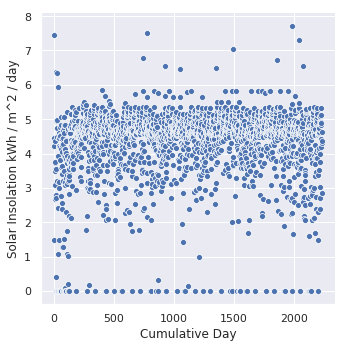

In [116]:
import seaborn as sns
sns.set()

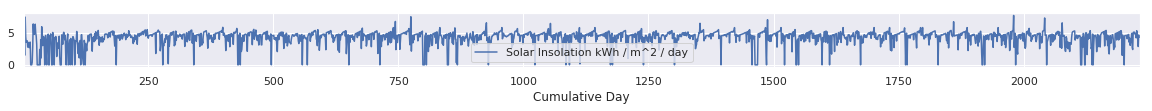

In [117]:
daily_df.plot("Cumulative Day", "Solar Insolation kWh / m^2 / day", figsize=(20, 1))

In [154]:
totals_list = []
for month in range(0, 12):
    new_list = []
    for octa in range(3, 11):
        new_list.append(monthly_cloudiness[month][octa] + monthly_cloudiness[month + 12][octa]
                        + monthly_cloudiness[month + 24][octa] + monthly_cloudiness[month + 36][octa]
                        + monthly_cloudiness[month + 48][octa] + monthly_cloudiness[month + 60][octa])
    totals_list.append(new_list)

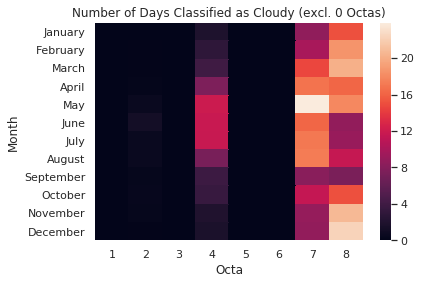

In [162]:
import matplotlib.pyplot as plt

ytick_list = ["January", "February", "March", "April", "May", "June",
            "July", "August", "September", "October", "November", "December"]
xtick_list = ["1", "2", "3", "4", "5", "6", "7", "8"]
sns.heatmap(np.array(totals_list), xticklabels=xtick_list, yticklabels=ytick_list),

plt.ylabel("Month")
plt.xlabel("Octa")
plt.title("Number of Days Classified as Cloudy (excl. 0 Octas)")
plt.show()